In [1]:
import sqlite3

import dask.dataframe as dd
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from dask.distributed import Client
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

from utils.constants import BigMarkets, Correspondence, SmallMarkets

In [2]:
client = Client(n_workers=6)
client

/home/adeye/anaconda3/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38245 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38245/status,
Dashboard: http://127.0.0.1:38245/status,Workers: 6
Total threads: 12,Total memory: 15.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36987,Workers: 6
Dashboard: http://127.0.0.1:38245/status,Total threads: 12
Started: Just now,Total memory: 15.25 GiB
Comm: tcp://127.0.0.1:40365,Total threads: 2
Dashboard: http://127.0.0.1:41679/status,Memory: 2.54 GiB
Nanny: tcp://127.0.0.1:44455,


# Big Market vs Small Market Teams Case Study

<div class="alert alert-block alert-success">
    In this notebook, we will analyze the relationship that may exist between the results of a team and their popularity on Youtube. We definend the popularity of a team as the view ratio of that team compared to all the views generated by basketball and NBA videos during that month. To have a more interesting and concrete view on this subject, we decided to conduct our analysis on 2 separated sets of teams.<br> 
The first set correspond to the <b>big market teams</b>, these teams usually represent big cities or very dense cities such as the New York Knicks, the Los Angeles Lakers or the Chicago Bulls. These cities represent a big market as they are the most supported at the national and international level. <br>
The second set represents the <b> small market teams </b>, these teams are usually less supported by the NBA fans as they represent cities that are less demographically dense or where basketball is not very popular.

<div class="alert alert-block alert-info">
Our first step is to prepare the dataframe on which we will conduct our analysis. We then load our data in parquet format and filter the categories of videos that are the most insightful for us. This step permits us to focus on the videos that are the most interesting for our research, remove noise from irrelevant categories and make our queries faster. <br>
Therefore, we filter our videos to only keep categories Sports, People & Blogs and Entertainment.

In [3]:
video_metadata_df = dd.read_parquet("./data/video_metadata/parquet/")
video_metadata_df["upload_date"] = dd.to_datetime(video_metadata_df.upload_date)

In [ ]:
video_metadata_df_sports = video_metadata_df[video_metadata_df["categories"].isin(["Sports", "People & Blogs", "Entertainment"])]
video_metadata_df_sports["tags"] = video_metadata_df_sports["tags"].str.lower()
video_metadata_df_sports["tags"] = video_metadata_df_sports["tags"].apply(lambda x: f",{x},")

In [5]:
# video_metadata_df_sports = video_metadata_df_sports[video_metadata_df_sports['tags'].str.contains('basketball')]

date_obj = video_metadata_df_sports.upload_date.dt
group_by = [date_obj.year, date_obj.month, video_metadata_df.categories]

video_metadata_df_sports_grouped = video_metadata_df_sports[["upload_date"]].groupby(by=group_by).count().persist()

<div class="alert alert-block alert-info">
To only keep the videos that are related to our main subject, we filter another time on the tags of the videos and remove all videos that do not contain the tag "nba" or "basketball".

In [7]:
required_tags = ["nba", "basketball"]

# Verifying that each video contains the required tags
nba_basketball_df = video_metadata_df_sports[video_metadata_df_sports["tags"].str.contains(f',{",|,".join(required_tags)},')].persist()
nba_basketball_df["year_month"] = dd.to_datetime(
    nba_basketball_df.upload_date.dt.year.astype("str") + "-" + nba_basketball_df.upload_date.dt.month.astype("str")
)

In [8]:
nba_basketball_df.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,year_month
12154,People & Blogs,UCzVxzz60KHq5Bgqf1zqoocg,2019-11-17 22:51:21.268794,Lacey Leaves Us! Crazy Basketball!\n\nWhat a ...,12.0,Roa9Qlaao3k,590,1232.0,",lacey leaves us,crazy basketball,lacey,crazy,...",LACEY LEAVES US! | CRAZY BASKETBALL!,2018-01-20,42250,2018-01-01
12171,People & Blogs,UCzVxzz60KHq5Bgqf1zqoocg,2019-11-17 22:51:31.053243,Dance! Cheer at Basketball! Vlogmas Day 16!\...,7.0,ta-GIdaF7k8,477,770.0,",halftime performace,cheer at basketball,vlogm...",HALFTIME PERFORMANCE! | CHEER AT BASKETBALL! |...,2017-12-16,17340,2017-12-01
12183,People & Blogs,UCzVxzz60KHq5Bgqf1zqoocg,2019-11-17 22:51:37.907564,2017 Vlogmas day 2! Christmas Countdown!\n\nI...,9.0,ATgptS5ETDs,761,1206.0,",2017 vlogmas day 2,christmas countdown,cheer ...",2017 VLOGMAS DAY 2! | CHRISTMAS COUNTDOWN! | C...,2017-12-02,33586,2017-12-01
12432,People & Blogs,UCzVxzz60KHq5Bgqf1zqoocg,2019-11-17 22:51:39.707546,Big Splash!\n\n♥FOLLOW US ON SOCIAL MEDIA♥\n\n...,4.0,2O_tokm8Fl0,672,408.0,",premiere_elements_13,crazy middles,big splash...",BIG SPLASH!,2015-05-06,22445,2015-05-01
28845,Entertainment,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:37:59.756743,Irene brings by her friend Maxine (Jillian Mit...,3.0,I1vC9mjIz6k,579,104.0,",joiridacheatham,hot,headz,episode,the,playa,c...",Hot Headz - Episode 8 (THE PLAYAS CRUSH),2012-05-11,6552,2012-05-01


<div class="alert alert-block alert-info">
We import our dictionnary of big and small market teams from our helper file. 

In [9]:
BigMarkets

{'LA': ['los angeles', 'la', 'lakers'],
 'NY': ['knicks', 'new york', 'ny'],
 'CH': ['bulls', 'chicago'],
 'PH': ['76ers', 'seventy sixers', 'seventysixers', 'philadelphia', 'phila'],
 'DS': ['mavericks', 'mavs', 'dallas'],
 'AT': ['hawks', 'atlanta', 'atl'],
 'BO': ['celtics', 'boston'],
 'GSW': ['gsw',
  'golden state warriors',
  'golden state',
  'warriors',
  'dubs',
  'dubs nation',
  'dubsnation']}

In [10]:
SmallMarkets

{'ME': ['memphis', 'grizzlies'],
 'NO': ['pelicans', 'pels', 'neworleans', 'new orleans', 'nola'],
 'OKC': ['okc', 'oklahomacitythunder', 'oklahoma'],
 'MB': ['bucks', 'milwaukee'],
 'SA': ['spurs', 'san antonio', 'sanantonio'],
 'UT': ['utah jazz', 'utahjazz', 'utah', 'jazz'],
 'IN': ['pacers', 'indiana', 'indi'],
 'PT': ['trailblazers', 'trail blazers', 'blazers', 'portland']}

<div class="alert alert-block alert-info">
We groupby the videos according to their respective team, sum the number of views for each team on a monthly basis, label each team with its market size and finally calculate its view ratio compared to all NBA/Basketball views. 

In [11]:
nba_basketball_views_per_year_df = nba_basketball_df[["year_month", "view_count"]].groupby("year_month").sum().persist().compute()
nba_basketball_views_per_year_df.rename(columns={"view_count": "total_nba_views"}, inplace=True)

dd_dict = {}

# Getting the total amount of views per month for every big market and small market team
for key, value in {**BigMarkets, **SmallMarkets}.items():

    team_df = nba_basketball_df[nba_basketball_df["tags"].str.contains(f',{",|,".join(value)},')]
    # team_df["year_month"] = team_df.upload_date.dt.year.astype("str") + "-" + team_df.upload_date.dt.month.astype("str")
    team_df = team_df[["year_month", "view_count"]].groupby("year_month").sum()

    team_df = team_df.reset_index()

    team_df["team"] = key
    team_df["market_size"] = "small" if key in SmallMarkets else "big"
    team_df = team_df.persist().compute()

    dd_dict[key] = team_df

In [12]:
all_team_results = pd.concat([v for k, v in dd_dict.items()])
all_team_results = all_team_results.merge(nba_basketball_views_per_year_df, on="year_month")
all_team_results["total_nba_view_percentage"] = all_team_results["view_count"] / all_team_results["total_nba_views"]

<div class="alert alert-block alert-info">
To compare our view ratio with the teams' results, we import from our database the monthly occupancy rate of the stadium of each team and the winning rate on the matches since the beginning of each season.

In [13]:
con = sqlite3.connect("data/nba_api.sqlite")

In [14]:
occupancy_rate_df = pd.read_sql_query(
    """select home, avg(attendance) as avg_attendace, round(avg(attendance/season_high_attendance*100),2) as avg_occupancy_rate, strftime('%Y-%m',time) as year_month
from game_data
group by home, year_month""",
    con,
)
occupancy_rate_df = occupancy_rate_df.reset_index()

display(occupancy_rate_df.home.unique())

occupancy_rate_df = occupancy_rate_df[occupancy_rate_df["home"].isin(Correspondence.keys())]


winning_rate_df = pd.read_sql_query(
    """
select home as team,
       strftime('%Y-%m', time)                                                                         as year_month,

       last_value(curr_season_win_pct) over (partition by home, strftime('%Y-%m', time) order by time) as win_percentage
from game_data
group by home, year_month;
""",
    con,
)
winning_rate_df = winning_rate_df.reset_index()
winning_rate_df = winning_rate_df[winning_rate_df["team"].isin(Correspondence.keys())]

winning_rate_df["year_month"] = pd.to_datetime(winning_rate_df["year_month"])
occupancy_rate_df["year_month"] = pd.to_datetime(occupancy_rate_df["year_month"])

array(['Atlanta Hawks', 'Boston Celtics', 'Brooklyn Nets',
       'Charlotte Bobcats', 'Charlotte Hornets', 'Chicago Bulls',
       'Cleveland Cavaliers', 'Dallas Mavericks', 'Denver Nuggets',
       'Detroit Pistons', 'Golden State Warriors', 'Houston Rockets',
       'Indiana Pacers', 'Los Angeles Clippers', 'Los Angeles Lakers',
       'Memphis Grizzlies', 'Miami Heat', 'Milwaukee Bucks',
       'Minnesota Timberwolves', 'New Jersey Nets', 'New Orleans Hornets',
       'New Orleans Pelicans', 'New Orleans/Oklahoma City Hornets',
       'New York Knicks', 'Oklahoma City Thunder', 'Orlando Magic',
       'Philadelphia 76ers', 'Phoenix Suns', 'Portland Trail Blazers',
       'Sacramento Kings', 'San Antonio Spurs', 'Seattle SuperSonics',
       'Toronto Raptors', 'Utah Jazz', 'Washington Wizards'], dtype=object)

In [15]:
winning_rate_df["team"] = winning_rate_df["team"].apply(lambda x: Correspondence[x])
occupancy_rate_df["team"] = occupancy_rate_df["home"].apply(lambda x: Correspondence[x])

In [16]:
winning_rate_df.head()

,index,team,year_month,win_percentage
0,0,AT,2004-11-01,0.000000
1,1,AT,2004-12-01,0.133333
2,2,AT,2005-01-01,0.161290
3,3,AT,2005-02-01,0.195652
4,4,AT,2005-03-01,0.172414


In [17]:
all_team_results = all_team_results.merge(winning_rate_df.drop(["index"], axis=1), on=["team", "year_month"], how="inner")
display(all_team_results.sort_values("year_month"))
all_team_results = all_team_results.merge(occupancy_rate_df.drop(["index", "home"], axis=1), on=["team", "year_month"], how="inner")
all_team_results

,year_month,view_count,team,market_size,total_nba_views,total_nba_view_percentage,win_percentage
1121,2006-02-01,14885.0,LA,big,47835.0,0.311174,0.500000
1126,2006-04-01,196243.0,PH,big,488786.0,0.401491,0.472222
1127,2006-11-01,41641.0,AT,big,1069420.0,0.038938,0.500000
1074,2007-02-01,98891.0,SA,small,38436196.0,0.002573,0.666667
1068,2007-02-01,1173066.0,LA,big,38436196.0,0.030520,0.566038
...,...,...,...,...,...,...,...
170,2018-05-01,40119467.0,BO,big,773270499.0,0.051883,0.670330
173,2018-05-01,11117246.0,UT,small,773270499.0,0.014377,0.582418
172,2018-05-01,4024547.0,NO,small,773270499.0,0.005205,0.595506
171,2018-05-01,145213889.0,GSW,big,773270499.0,0.187792,0.719101


,year_month,view_count,team,market_size,total_nba_views,total_nba_view_percentage,win_percentage,avg_attendace,avg_occupancy_rate
0,2016-04-01,43943996.0,LA,big,340539239.0,0.129042,0.210526,18997.000000,100.00
1,2016-04-01,114950.0,NY,big,340539239.0,0.000338,0.402597,19812.000000,100.00
2,2016-04-01,3870363.0,CH,big,340539239.0,0.011365,0.500000,22053.333333,95.25
3,2016-04-01,743567.0,PH,big,340539239.0,0.002183,0.116883,15633.500000,75.17
4,2016-04-01,925314.0,DS,big,340539239.0,0.002717,0.512821,20266.200000,98.78
...,...,...,...,...,...,...,...,...,...
1123,2007-11-01,37727.0,BO,big,33575067.0,0.001124,1.000000,18624.000000,100.00
1124,2007-11-01,34714.0,GSW,big,33575067.0,0.001034,0.000000,19483.833333,93.96
1125,2007-11-01,63139.0,MB,small,33575067.0,0.001881,0.333333,15332.428571,81.92
1126,2006-04-01,196243.0,PH,big,488786.0,0.401491,0.472222,17895.400000,86.65


In [18]:
all_team_results.to_csv("data/all_team_results.csv")

 <div class="alert alert-block alert-info">

Hypothesis : Is the correlation between results and popularity bigger for big market teams than for small market teams? 
    
To verify our hypothesis, we compute the correlation for the 2 sets of teams between their winning rate and their monthly view rate.

In [19]:
small_market_correlations = {}
for team in SmallMarkets:
    df = all_team_results[all_team_results["team"] == team]
    small_market_correlations[team] = pearsonr(df["total_nba_view_percentage"], df["win_percentage"]).statistic


big_market_correlations = {}
for team in BigMarkets:
    df = all_team_results[all_team_results["team"] == team]
    big_market_correlations[team] = pearsonr(df["total_nba_view_percentage"], df["win_percentage"]).statistic

In [20]:
big_market_correlations

{'LA': 0.1316838140801585,
 'NY': 0.34849452858632335,
 'CH': 0.11432167983777058,
 'PH': 0.11647017448293932,
 'DS': 0.11370818659094772,
 'AT': -0.04634955603402087,
 'BO': 0.06604068079760254,
 'GSW': 0.3146203789556997}

In [21]:
small_market_correlations

{'ME': -0.07000533625121828,
 'NO': 0.09677858290758645,
 'OKC': 0.06598821576952683,
 'MB': 0.1430443366597352,
 'SA': -0.01302775162457354,
 'UT': 0.09458542438174612,
 'IN': 0.25046606580428066,
 'PT': -0.06494037482974846}

In [22]:
lakers_df = all_team_results[(all_team_results["team"] == "LA") & (all_team_results["year_month"] > "2010")].sort_values("year_month")

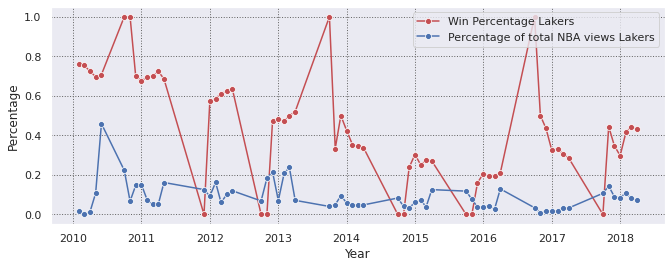

In [46]:
sns.set(rc={"figure.figsize": (11, 4)})
sns.set_style("darkgrid", {"grid.color": ".4", "grid.linestyle": ":"})
ax = plt.subplot
ax = sns.lineplot(
    x="year_month", y="win_percentage", data=lakers_df, color="r", marker="o", palette=["red"], legend="brief", label="Win Percentage Lakers"
)
ax = sns.lineplot(
    x="year_month", y="total_nba_view_percentage", data=lakers_df, marker="o", color="b", legend="brief", label="Percentage of total NBA views Lakers"
)
ax.set(xlabel="Year", ylabel="Percentage")

plt.show()

 <div class="alert alert-block alert-info">
The results are not conclusive, we are therefore going to research this part more in the next steps. 
</div>